In [1]:
import pandas as pd
import numpy as np
import os
import math
import pymysql

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# use get_db_url function to connect to the codeup db
from env import get_db_url
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans, dbscan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,  LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


import zillow_wrangle

# What's causing the error in our Zestimates

--- 

## Project Goal 

- The goal of this project is to create a reproducible  machine learning regression model and clusters to find the key drivers of error in Zestimates 
- In order to identify key drivers of errors in our Zestimate, this project will explore the data and indentify clusters which can help lower the estimate. This notebook serves as a way to understand why and how I made the prediction model.

---

## Project Description

- The residential real estate market is constantly evolving and fluctating. Zestimates offer a way for our users to to understand and negotiate good deals by having a good idea what the house should be worth. An accurate algorithim is essential in user statisfaction and a way for them to properly plan their home purchase. Lowering the error will inspire more confidence with users trusting the zestimate and help Zillow grow. 

---

### Key Questions

1. Does logerror vary by location using polar coordinates?

2. Does log erorr vary by quarter sold?

3. Does log error vary by transaction month and census location?

4. Does log error vary by county and time sold?

5. Does the product of square feet and the bed bath ratio affect log error?

--- 
## Data Acquisition
- Brought in all the necessary data using mySQL via the zillow_wrangle.py file.


In [2]:
# Bringing in the zillow data set
df = zillow_wrangle.wrangle_zillow()

In [3]:
# Transforming the Lat Long to cartesian coordinates
df = zillow_wrangle.latlong_to_cart(df)

In [4]:
# Transforming to polar coordinates to have 2 dimensional distance
df['rho'], df['phi'] = zillow_wrangle.cart2pol(df.x, df.y)

In [5]:
# Combining the two transaction columns into one
df = zillow_wrangle.combine_transactions(df)

In [6]:
# Changing and setting setting date features to be by month and quarter
df = zillow_wrangle.add_date_features(df)

In [7]:
# Removing the now redundant columns after the feature engineering
df = df.drop(columns=['bedroomcnt', 'bathroomcnt', 'x', 'y', 'z', 'coslat', 'coslong', 'sinlong', 'roomcnt', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'latitude', 'longitude', 'lat', 'long'])

## Acquisition and Prep Takeaways 
- The project asked for single unit/ single family homes so I filtered by unit count equal to 1 and by single family home.
- The resulting query has 79661 rows representing a transaction from fiscal year 2017
- My intial exploration saw the categories with the least amount of nulls and that transaction year was not a full year
- The query resulted in a minimal amount of nulls which I dropped instead of imputing to keep the data original and still retained over 90% of the data
- I transformed the nulls  to zeros for the pool and garage columns. They are very large features and have a high likelihood of being added if presented. Since there was no zeros and only nulls, I interpreted the nulls to be zeros.


---

## Data Exploration
- The 2017 data was incomplete becuase it only showed data for the 9 months of year, and to get the full year I used fiscal year and brought in data from the last three months of 2016. This gave me a full three quarters
- I split the transactions into months and quarters to get a better sense of logerrror drivers
- There is some underlying features that we do not have recored that influence logerror in transaction months. I searched all basic features and saw no variance in logerror. 
- I used raw census data over regular becuase it contained no nulls and didn't need to drop any. Precise location was not needed since I was binning them instead.
- To see my exploration please see the explore files 


In [8]:
# Splitting the data to ensure no leakage between train test and split
train, validate, test = zillow_wrangle.split_data(df)

In [9]:
# Looking at the overall shapes to see if the split worked correctly
df.shape, train.shape, validate.shape, test.shape

((79661, 13), (50982, 13), (12746, 13), (15933, 13))

In [10]:
# cutting the only most extreme outliers and will handle with a robust scaler later
train = zillow_wrangle.remove_outliers(train, 3, ['calculatedfinishedsquarefeet','garagecarcnt'])
train.shape

(50218, 13)

In [11]:
# # Assigning the county names to the region id county to see what the counties names are
# def county_name(county):
#     if county == 2061.0:
#         return 'Los Angeles'
#     elif county == 1286.0:
#         return 'Orange'
#     elif county == 3101.0:
#         return 'Ventura'

# train['county'] = train.regionidcounty.apply(county_name)
# validate['county'] = train.regionidcounty.apply(county_name)
# test['county'] = train.regionidcounty.apply(county_name)

# Q1. Does log error vary polar coordinate location?

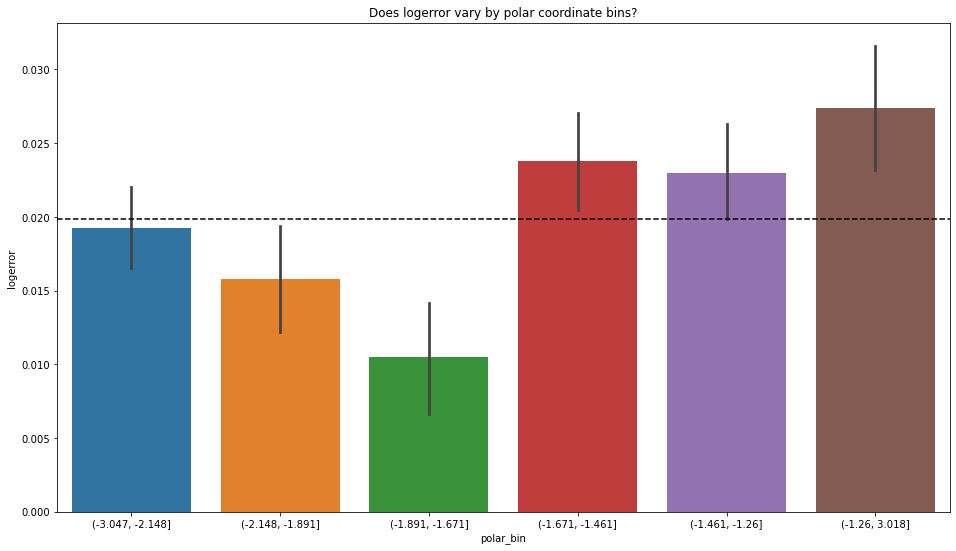

In [12]:
logmean = train.logerror.mean()

# Changing the cartesian coordinates to be polar coordinates
train['polar_combo'] = train.rho * train.phi
validate['polar_combo'] = validate.rho * validate.phi
test['polar_combo'] = test.rho * test.phi


# Separating the locations into bins to better visualize the data against log error. The bins were found via qcut in explore
train['polar_bin'] = pd.cut(train.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])
validate['polar_bin'] = pd.cut(validate.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])
test['polar_bin'] = pd.cut(test.polar_combo, [-3.0469999999999997, -2.148, -1.891, -1.671, -1.461, -1.26, 3.018])

# Plotting the figure
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='polar_bin', y='logerror')
plt.title('Does logerror vary by polar coordinate bins?')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

### Log error does vary by location. The current model is more accurate for the first three bins compared to the last three
Ho - Log error is the equal for all locations
Ha - Log error is not equal for all locations
Result - We reject the null hypothesis. 

---
# Q2. Does log error vary depending on which quarter the house was sold?

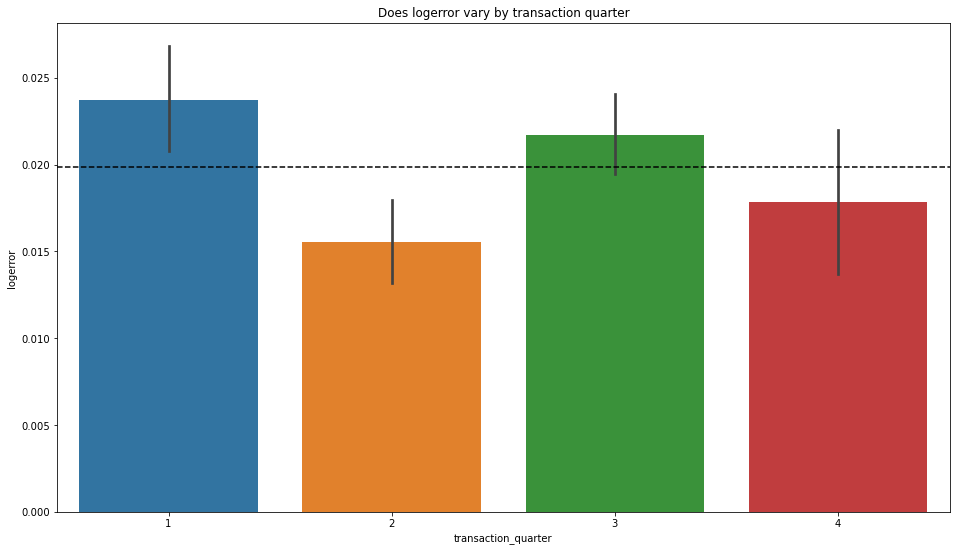

In [13]:
# Plotting the chart for transaction quarter against logerro
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='transaction_quarter', y='logerror')
plt.title('Does logerror vary by transaction quarter')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

## The log error does vary by the quarter it was sold. The current model better predicts prices during the 2 and 4th quarter 

Ho - Log error is equal for all quarters
Ha - Lor error is not equal for all quarters
Result - We reject the null hypothesis
---

# Q3. Does log error vary by the month it was sold and by census location?

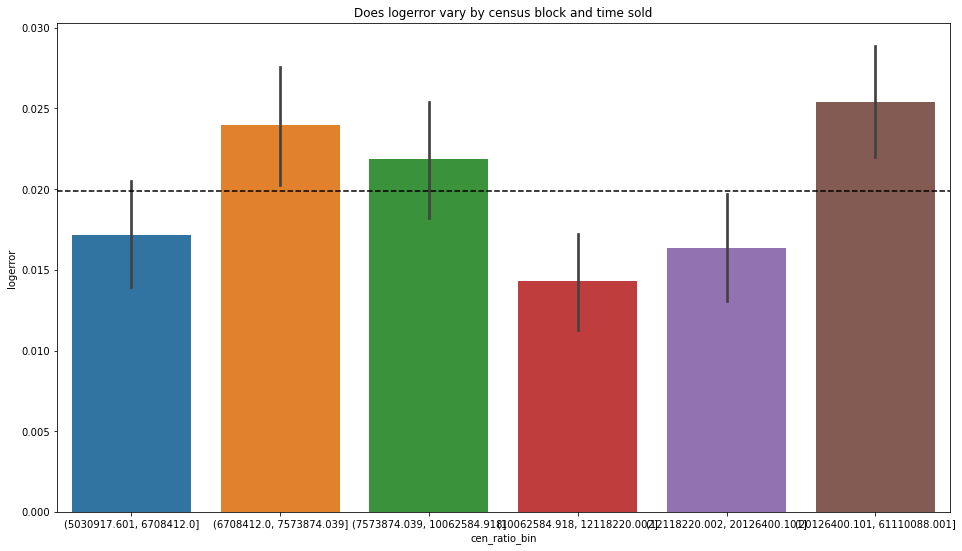

In [14]:
# Creating the ratio for the feature and applying it to all groups
train['cen_ratio'] = df.rawcensustractandblock / df.transaction_month
validate['cen_ratio'] = df.rawcensustractandblock / df.transaction_month
test['cen_ratio'] = df.rawcensustractandblock / df.transaction_month

# Setting the bins for the data to fall into 
train['cen_ratio_bin'] = pd.cut(train.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.002, 20126400.101, 61110088.001])
validate['cen_ratio_bin'] = pd.cut(validate.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.009, 20126400.101, 61110088.001])
test['cen_ratio_bin'] = pd.cut(test.cen_ratio, [5030917.601, 6708412.0, 7573874.039, 10062584.918, 12118220.002, 20126400.101, 61110088.001])

# Creating the visual against log erorr
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='cen_ratio_bin', y='logerror')
plt.title('Does logerror vary by census block and time sold')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()



## The lor error does vary and preforms better than average on half of the data with more error in the other half.
Ho - Log error is equal across all bins
Ha - Lor error is not equal across all bins
Result - We reject the null hypothesis

---
# Q4. How does log error vary by county and time sold?

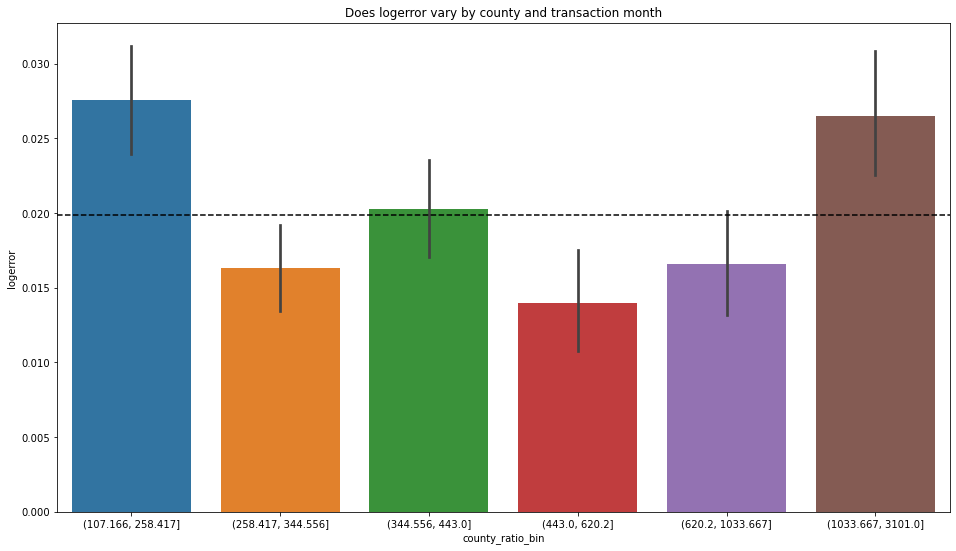

In [15]:
# Creating the feature by dividing the county by transaction month
train['county_ratio'] = train.regionidcounty / train.transaction_month
validate['county_ratio'] = validate.regionidcounty / validate.transaction_month
test['county_ratio'] = test.regionidcounty / test.transaction_month

# Creating the binned data from qcut in explore
train['county_ratio_bin'] = pd.cut(train.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])
validate['county_ratio_bin'] = pd.cut(validate.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])
test['county_ratio_bin'] = pd.cut(test.county_ratio, [107.166, 258.417, 344.556, 443.0, 620.2, 1033.667, 3101.0])

# Plotting the graph
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='county_ratio_bin', y='logerror')
plt.title('Does logerror vary by county and transaction month')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()


## This was to see if the time of the year affected the county in which the property was sold. We can see the the log error was different for three of the 6 bins of data

Ho - The log error is equal for all bins
Ha - The log error is not equal for all bins
Result - We reject the null hypothesis

---

# Q5. Does the product of square feet and the bed bath ratio affect log error?

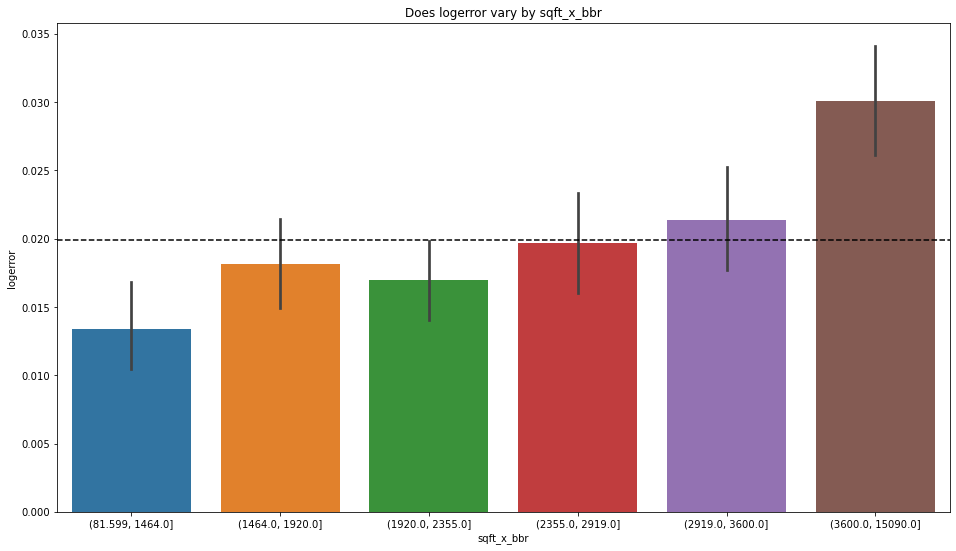

In [16]:
# Creating the feature
train['sqf_bbr'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio
validate['sqf_bbr'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio
test['sqf_bbr'] = df.calculatedfinishedsquarefeet * df.bed_bath_ratio

# Binning the feature
train['sqft_x_bbr'] = pd.cut(train.sqf_bbr, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])
validate['sqft_x_bbr'] = pd.cut(validate.sqf_bbr, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])
test['sqft_x_bbr'] = pd.cut(test.sqf_bbr, [81.59899999999999, 1464.0, 1920.0, 2355.0, 2919.0, 3600, 15090.0])

# Creating the graph
plt.figure(figsize=(16, 9))
sns.barplot(data = train, x='sqft_x_bbr', y='logerror')
plt.title('Does logerror vary by sqft_x_bbr')
plt.axhline(logmean, ls = '--', color = 'black')
plt.show()

In [17]:
# Creating the Age bin from explore but did not put into questions 
train['age_bin'] = pd.cut(train.house_age,[0,25, 50, 75, 100])
validate['age_bin'] = pd.cut(validate.house_age,[0,25, 50, 75, 100])
test['age_bin'] = pd.cut(test.house_age,[0,25, 50, 75, 100])

# Creating census bins as well to aid in modeling but did not make it questions
train['raw_cen_bin'] = pd.cut(train.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])
validate['raw_cen_bin'] = pd.cut(validate.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])
test['raw_cen_bin'] = pd.cut(test.rawcensustractandblock, [60371011.1, 60373004.001, 60375711.022, 60590218.223, 61110091.001])


## As the ratio gets bigger the log error trends to the upside as the ratio increases. 
Ho - The logerror is the same for all ratio bins
Ha - The logerror is not equal for all bins

# Take aways
- The log error varies by location and setting it to polar coordinates makes the location easily measurable 
- The quarter in which the home was sold affects the home price
- The time sold and census location affects logerror
- The month when sold and county location affects logerror
- The product of sq ft and bed bath ratio has strong variance in logerror.
- Created the age bin in explore but did not include in questions

---
# Modeling Tweedie Regressor
- Please see my explore file to see how the other models preformed vs Tweedie
- Used RFE to determine the best features to use
- Using a Robust scaler because I still have some outliers left after removing the most extreme and keep the model as wide as possible
- I attempted clusters in explore but they did not impact the model and were not selected in RFE

In [18]:
# Scaling the data and reapply that to the dataframe
def split_scale(df):
    # Copy a new dataframe to perform feature engineering
    scaled_df = df.copy()
    scaler = RobustScaler()
    # Split the scaled data into train, validate, test
    train, validate, test = zillow_wrangle.split_data(scaled_df)
    # Columns to scale
    cols = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'rawcensustractandblock', 'garagecarcnt', 'house_age']
    # Fit numerical features to scaler
    scaler.fit(train[cols])
    # Set the features to transformed value
    train[cols] = scaler.transform(train[cols])
    validate[cols] = scaler.transform(validate[cols])
    test[cols] = scaler.transform(test[cols])
    return train, validate, test

In [19]:
#Using the Function to apply the scaled data to dataset
df = split_scale(df)

#Affirming that I have all the columns
train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'logerror',
       'transaction_month', 'transaction_quarter', 'polar_combo', 'polar_bin',
       'cen_ratio', 'cen_ratio_bin', 'county_ratio', 'county_ratio_bin',
       'sqf_bbr', 'sqft_x_bbr', 'age_bin', 'raw_cen_bin'],
      dtype='object')

In [21]:
#setting what columns to make dummies and adding to train
cols = ['polar_bin', 'age_bin', 'sqft_x_bbr', 'county_ratio_bin', 'raw_cen_bin']
train_dummy = pd.get_dummies(train[cols], dummy_na=False, drop_first=False)
x_train = pd.concat([train, train_dummy], axis =1)

#adding dummies to validate
validate_dummy = pd.get_dummies(validate[cols], dummy_na=False, drop_first=False)
x_validate = pd.concat([validate, validate_dummy], axis =1)

#Adding dummies to test
test_dummy = pd.get_dummies(test[cols], dummy_na=False, drop_first=False)
x_test = pd.concat([test, test_dummy], axis =1)

#Checking to see if it worked
x_train.columns

Index(['calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'rawcensustractandblock', 'poolcnt', 'regionidcounty', 'garagecarcnt',
       'bed_bath_ratio', 'house_age', 'rho', 'phi', 'logerror',
       'transaction_month', 'transaction_quarter', 'polar_combo', 'polar_bin',
       'cen_ratio', 'cen_ratio_bin', 'county_ratio', 'county_ratio_bin',
       'sqf_bbr', 'sqft_x_bbr', 'age_bin', 'raw_cen_bin',
       'polar_bin_(-3.047, -2.148]', 'polar_bin_(-2.148, -1.891]',
       'polar_bin_(-1.891, -1.671]', 'polar_bin_(-1.671, -1.461]',
       'polar_bin_(-1.461, -1.26]', 'polar_bin_(-1.26, 3.018]',
       'age_bin_(0, 25]', 'age_bin_(25, 50]', 'age_bin_(50, 75]',
       'age_bin_(75, 100]', 'sqft_x_bbr_(81.599, 1464.0]',
       'sqft_x_bbr_(1464.0, 1920.0]', 'sqft_x_bbr_(1920.0, 2355.0]',
       'sqft_x_bbr_(2355.0, 2919.0]', 'sqft_x_bbr_(2919.0, 3600.0]',
       'sqft_x_bbr_(3600.0, 15090.0]', 'county_ratio_bin_(107.166, 258.417]',
       'county_ratio_bin_(258.417, 344.556]',
   

In [22]:
# Dropping the redunant columns
x_train = x_train.drop(columns=['polar_bin', 'raw_cen_bin', 'age_bin', 'sqft_x_bbr', 'county_ratio_bin', 'cen_ratio_bin', 'phi', 'rho', 'lotsizesquarefeet', 'house_age'])



In [23]:
# Setting the variables and target variable
X_train = x_train.drop(columns = 'logerror')
X_validate = x_validate.drop(columns = 'logerror')
X_test = x_test.drop(columns = 'logerror')

y_train = x_train['logerror']
y_validate = x_validate['logerror']
y_test = x_test['logerror']

In [40]:
def select_rfe(x, y, k):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    rfe.fit(x, y)
    return x.columns[rfe.get_support()]

select_rfe(X_train, y_train, 16)

Index(['poolcnt', 'polar_bin_(-3.047, -2.148]', 'polar_bin_(-2.148, -1.891]',
       'polar_bin_(-1.891, -1.671]', 'polar_bin_(-1.671, -1.461]',
       'polar_bin_(-1.461, -1.26]', 'polar_bin_(-1.26, 3.018]',
       'age_bin_(0, 25]', 'age_bin_(25, 50]', 'age_bin_(50, 75]',
       'age_bin_(75, 100]', 'sqft_x_bbr_(81.599, 1464.0]',
       'sqft_x_bbr_(1464.0, 1920.0]', 'sqft_x_bbr_(1920.0, 2355.0]',
       'sqft_x_bbr_(2355.0, 2919.0]',
       'raw_cen_bin_(60375711.022, 60590218.223]'],
      dtype='object')

In [29]:
# Setting the features to use in my model 
X_train = X_train[['poolcnt', 'polar_bin_(-3.047, -2.148]', 'polar_bin_(-2.148, -1.891]',
       'polar_bin_(-1.891, -1.671]', 'polar_bin_(-1.671, -1.461]',
       'polar_bin_(-1.461, -1.26]', 'polar_bin_(-1.26, 3.018]',
       'age_bin_(0, 25]', 'age_bin_(25, 50]', 'age_bin_(50, 75]',
       'age_bin_(75, 100]', 'sqft_x_bbr_(81.599, 1464.0]',
       'sqft_x_bbr_(1464.0, 1920.0]', 'sqft_x_bbr_(1920.0, 2355.0]',
       'sqft_x_bbr_(2355.0, 2919.0]',
       'raw_cen_bin_(60375711.022, 60590218.223]']]
X_validate = X_validate[['poolcnt', 'polar_bin_(-3.047, -2.148]', 'polar_bin_(-2.148, -1.891]',
       'polar_bin_(-1.891, -1.671]', 'polar_bin_(-1.671, -1.461]',
       'polar_bin_(-1.461, -1.26]', 'polar_bin_(-1.26, 3.018]',
       'age_bin_(0, 25]', 'age_bin_(25, 50]', 'age_bin_(50, 75]',
       'age_bin_(75, 100]', 'sqft_x_bbr_(81.599, 1464.0]',
       'sqft_x_bbr_(1464.0, 1920.0]', 'sqft_x_bbr_(1920.0, 2355.0]',
       'sqft_x_bbr_(2355.0, 2919.0]',
       'raw_cen_bin_(60375711.022, 60590218.223]']] 
X_test = X_test[['poolcnt', 'polar_bin_(-3.047, -2.148]', 'polar_bin_(-2.148, -1.891]',
       'polar_bin_(-1.891, -1.671]', 'polar_bin_(-1.671, -1.461]',
       'polar_bin_(-1.461, -1.26]', 'polar_bin_(-1.26, 3.018]',
       'age_bin_(0, 25]', 'age_bin_(25, 50]', 'age_bin_(50, 75]',
       'age_bin_(75, 100]', 'sqft_x_bbr_(81.599, 1464.0]',
       'sqft_x_bbr_(1464.0, 1920.0]', 'sqft_x_bbr_(1920.0, 2355.0]',
       'sqft_x_bbr_(2355.0, 2919.0]',
       'raw_cen_bin_(60375711.022, 60590218.223]']]  

# Creating dataframe to analyze results
predictions_reg = pd.DataFrame({
    'actual': x_validate['logerror']
})            

In [31]:
# Setting the tweedie regressor model 
tweedie_reg = TweedieRegressor(power=0, alpha=0.5)

# Fitting the model to my train
tweedie_reg.fit(X_train, y_train)

#creating the column to house predictions
predictions_reg['tweedie'] = tweedie_reg.predict(X_validate)

#Creating baseline model to compare against
predictions_reg['baseline'] = x_train.logerror.mean()
predictions_reg.head()

#calculating the rmse for both
def calculate_rmse(y_predicted):
    return mean_squared_error(predictions_reg.actual, y_predicted, squared=False)

predictions_reg.apply(calculate_rmse).sort_values()

actual      0.000000
tweedie     0.152973
baseline    0.153083
dtype: float64

In [36]:
# Making predictions on the test data  used to determine RMSE
test_predictions = tweedie_reg.predict(X_test)
test_actual = x_test.logerror

RMSE = mean_squared_error(test_actual, test_predictions, squared=False)
RMSE
print("The model's RMSE is: "+"{:.5f}".format(RMSE))

The model's RMSE is: 0.16375


In [38]:
# Setting the base line in order to compare how it is. 
x_test['baseline'] = x_test.logerror.mean()

# Finding the RMSE of the baseline
test_baseline = mean_squared_error(x_test.logerror, x_test.baseline, squared=False)

# Printing the baseline 
print('Validation baseline RMSE: {:.5f}.'.format(test_baseline))

Validation baseline RMSE: 0.16383.


In [39]:
# Finding how much my model beat baseline by and printing the result in 
model_percent = abs((RMSE - test_baseline) / ((RMSE + test_baseline) / 2))

print("The model beat baseline by: "+"{:.2%}".format(model_percent))

The model beat baseline by: 0.05%


# Summary
* The tweedie regression model used on the data beat the baseline prediction by 0.05% on the test data
* There is some underlying features that I do not know which is causing an infulence on the logerror
* The top features to help predict the log error are the custom bins I made above.
* My clusters did not add to the model, so I did not select them 

---
# Recommendations
* Try to gain additional features that affect the logerror to determine more key errors
* Try to get better information to lower the amount of nulls for features that have strong correlation, such as construction quality
*  Compare these models to other states to see how logerror is affect and if the features here are unique to the LA area

---
# Next Steps
* Continue to explore the variables and bins of them to help lower log error
* Try new cluster combinations to see if any would help model preform any better
* Proof of concecpt - can continue to build and work on the model. 